In [1]:
#Loading libraries
library(ggplot2)
library(caret)
library(class)
library(corrplot)
library(MASS)
library(randomForest)
library(car)
library(glmnet)
library(dplyr)
library(psych)
library(rpart)

Loading required package: lattice

corrplot 0.92 loaded

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: carData

Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following object is masked from ‘package:randomForest’:

    combine


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘psych’


The following object is masked from ‘package:car’:

    logit


The following object is masked from ‘package:randomForest’:

    outlier


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




In [2]:
#Loading the data
data = read.csv('Crab.csv', header =1)
str(data)
#Make "Sex" variable categorical
data$Sex = as.factor(data$Sex)
summary(data)

'data.frame':	3893 obs. of  9 variables:
 $ Sex           : chr  "F" "M" "I" "F" ...
 $ Length        : num  1.438 0.887 1.038 1.175 0.887 ...
 $ Diameter      : num  1.175 0.65 0.775 0.887 0.662 ...
 $ Height        : num  0.412 0.212 0.25 0.25 0.212 ...
 $ Weight        : num  24.64 5.4 7.95 13.48 6.9 ...
 $ Shucked.Weight: num  12.33 2.3 3.23 4.75 3.46 ...
 $ Viscera.Weight: num  5.58 1.37 1.6 2.28 1.49 ...
 $ Shell.Weight  : num  6.75 1.56 2.76 5.24 1.7 ...
 $ Age           : int  9 6 6 10 6 8 15 10 13 7 ...


 Sex          Length          Diameter          Height           Weight       
 F:1225   Min.   :0.1875   Min.   :0.1375   Min.   :0.0000   Min.   : 0.0567  
 I:1233   1st Qu.:1.1250   1st Qu.:0.8750   1st Qu.:0.2875   1st Qu.:12.6722  
 M:1435   Median :1.3625   Median :1.0625   Median :0.3625   Median :22.7930  
          Mean   :1.3113   Mean   :1.0209   Mean   :0.3494   Mean   :23.5673  
          3rd Qu.:1.5375   3rd Qu.:1.2000   3rd Qu.:0.4125   3rd Qu.:32.7862  
          Max.   :2.0375   Max.   :1.6250   Max.   :2.8250   Max.   :80.1015  
 Shucked.Weight     Viscera.Weight      Shell.Weight           Age        
 Min.   : 0.02835   Min.   : 0.01418   Min.   : 0.04252   Min.   : 1.000  
 1st Qu.: 5.34388   1st Qu.: 2.66485   1st Qu.: 3.71378   1st Qu.: 8.000  
 Median : 9.53961   Median : 4.86194   Median : 6.66213   Median :10.000  
 Mean   :10.20734   Mean   : 5.13655   Mean   : 6.79584   Mean   : 9.955  
 3rd Qu.:14.27397   3rd Qu.: 7.20077   3rd Qu.: 9.35534   3rd Qu.:11.000

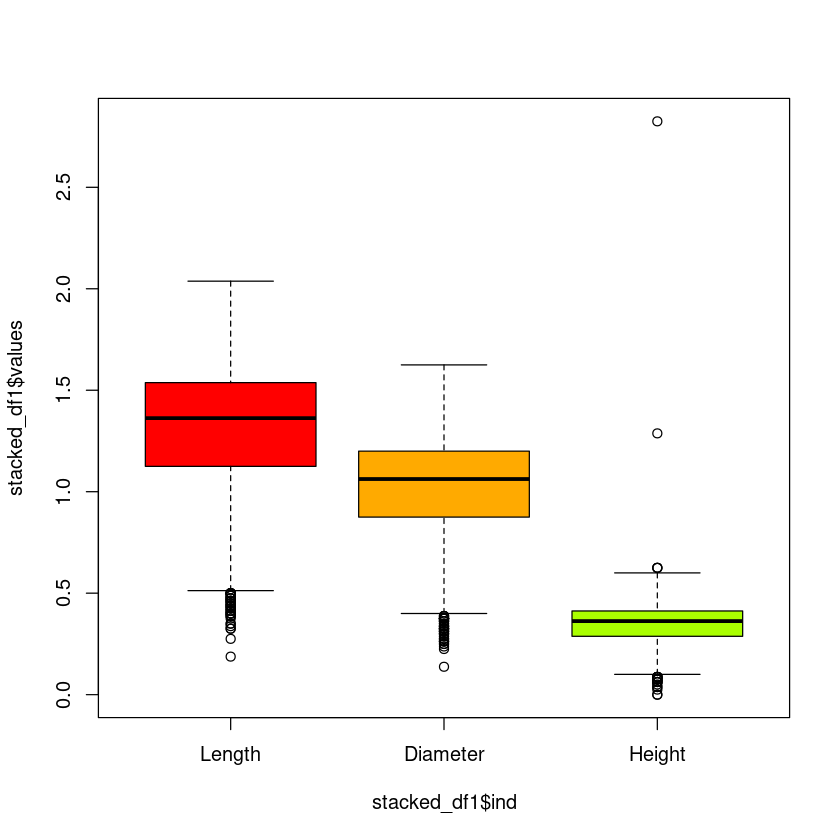

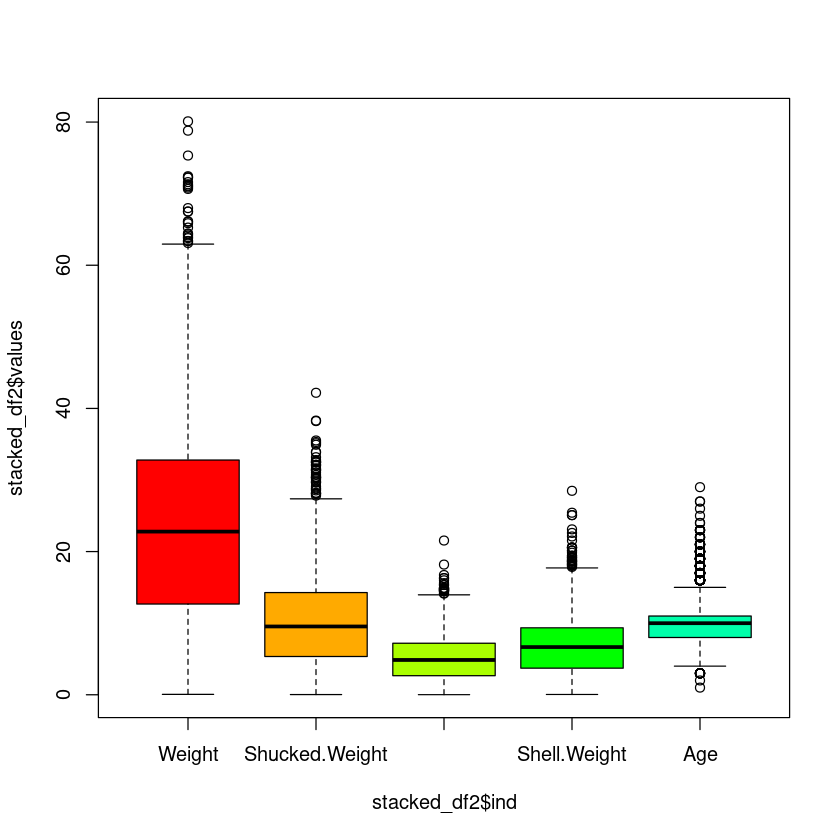

In [3]:
#Boxplots
stacked_df1 = stack(data[,c(2:4)])
boxplot(stacked_df1$values ~ stacked_df1$ind, col = rainbow(ncol(data)))
stacked_df2 = stack(data[,c(5:9)])
boxplot(stacked_df2$values ~ stacked_df2$ind, col = rainbow(ncol(data)))

In [ ]:
#Removing outliers
# Define the columns to process
cols <- c("Height", "Length", "Diameter", "Weight", 
          "Shucked.Weight", "Viscera.Weight", "Shell.Weight", "Age")

# Start with the original data
temp_data <- data

# Loop over each column name
for (col_name in cols) {
  # Identify outliers in the current column
  outliers <- boxplot(temp_data[[col_name]], plot = FALSE)$out
  
  # Remove rows containing these outliers
  temp_data <- temp_data[!(temp_data[[col_name]] %in% outliers), ]
}

# Final cleaned dataset
crabs <- temp_data

In [4]:
crabs = data

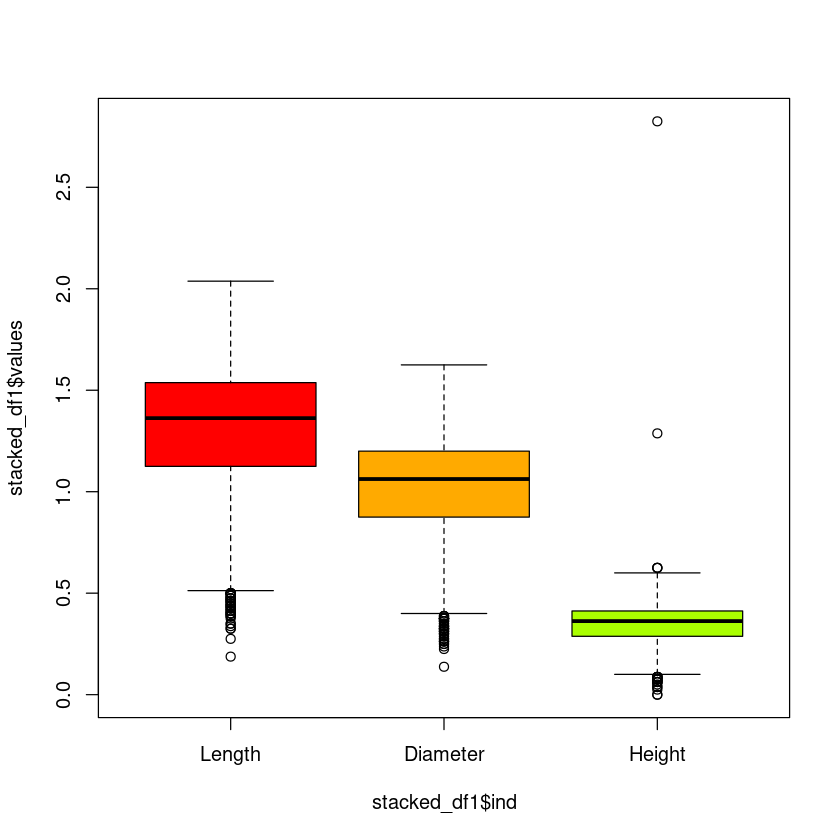

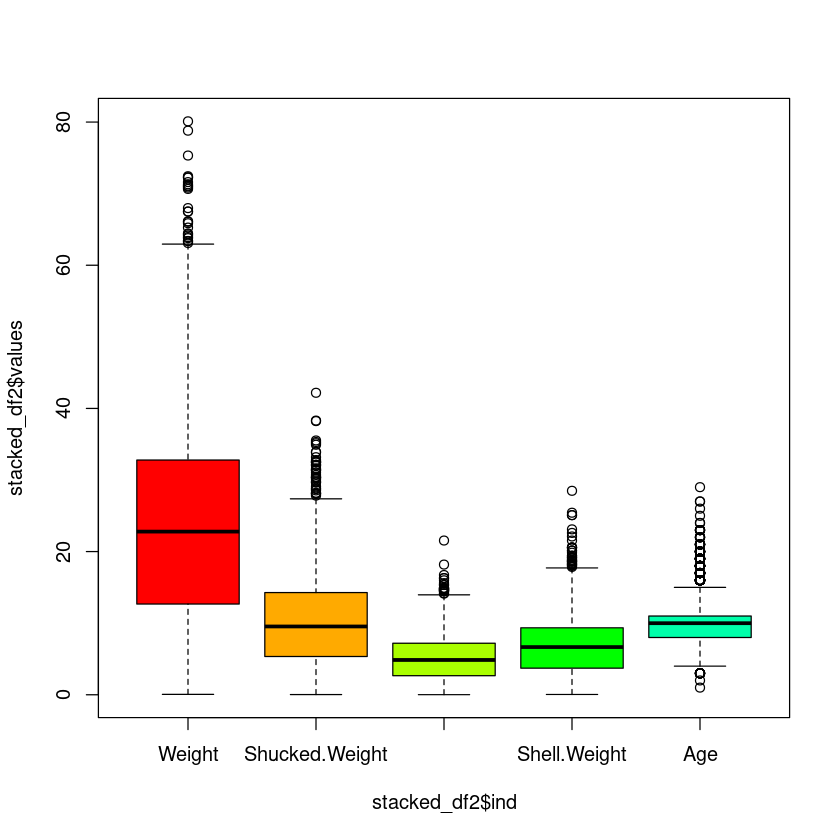

In [5]:
#Boxplots after removing outliers
stacked_df1 = stack(crabs[,c(2:4)])
boxplot(stacked_df1$values ~ stacked_df1$ind, col = rainbow(ncol(data)))
stacked_df2 = stack(crabs[,c(5:9)])
boxplot(stacked_df2$values ~ stacked_df2$ind, col = rainbow(ncol(data)))

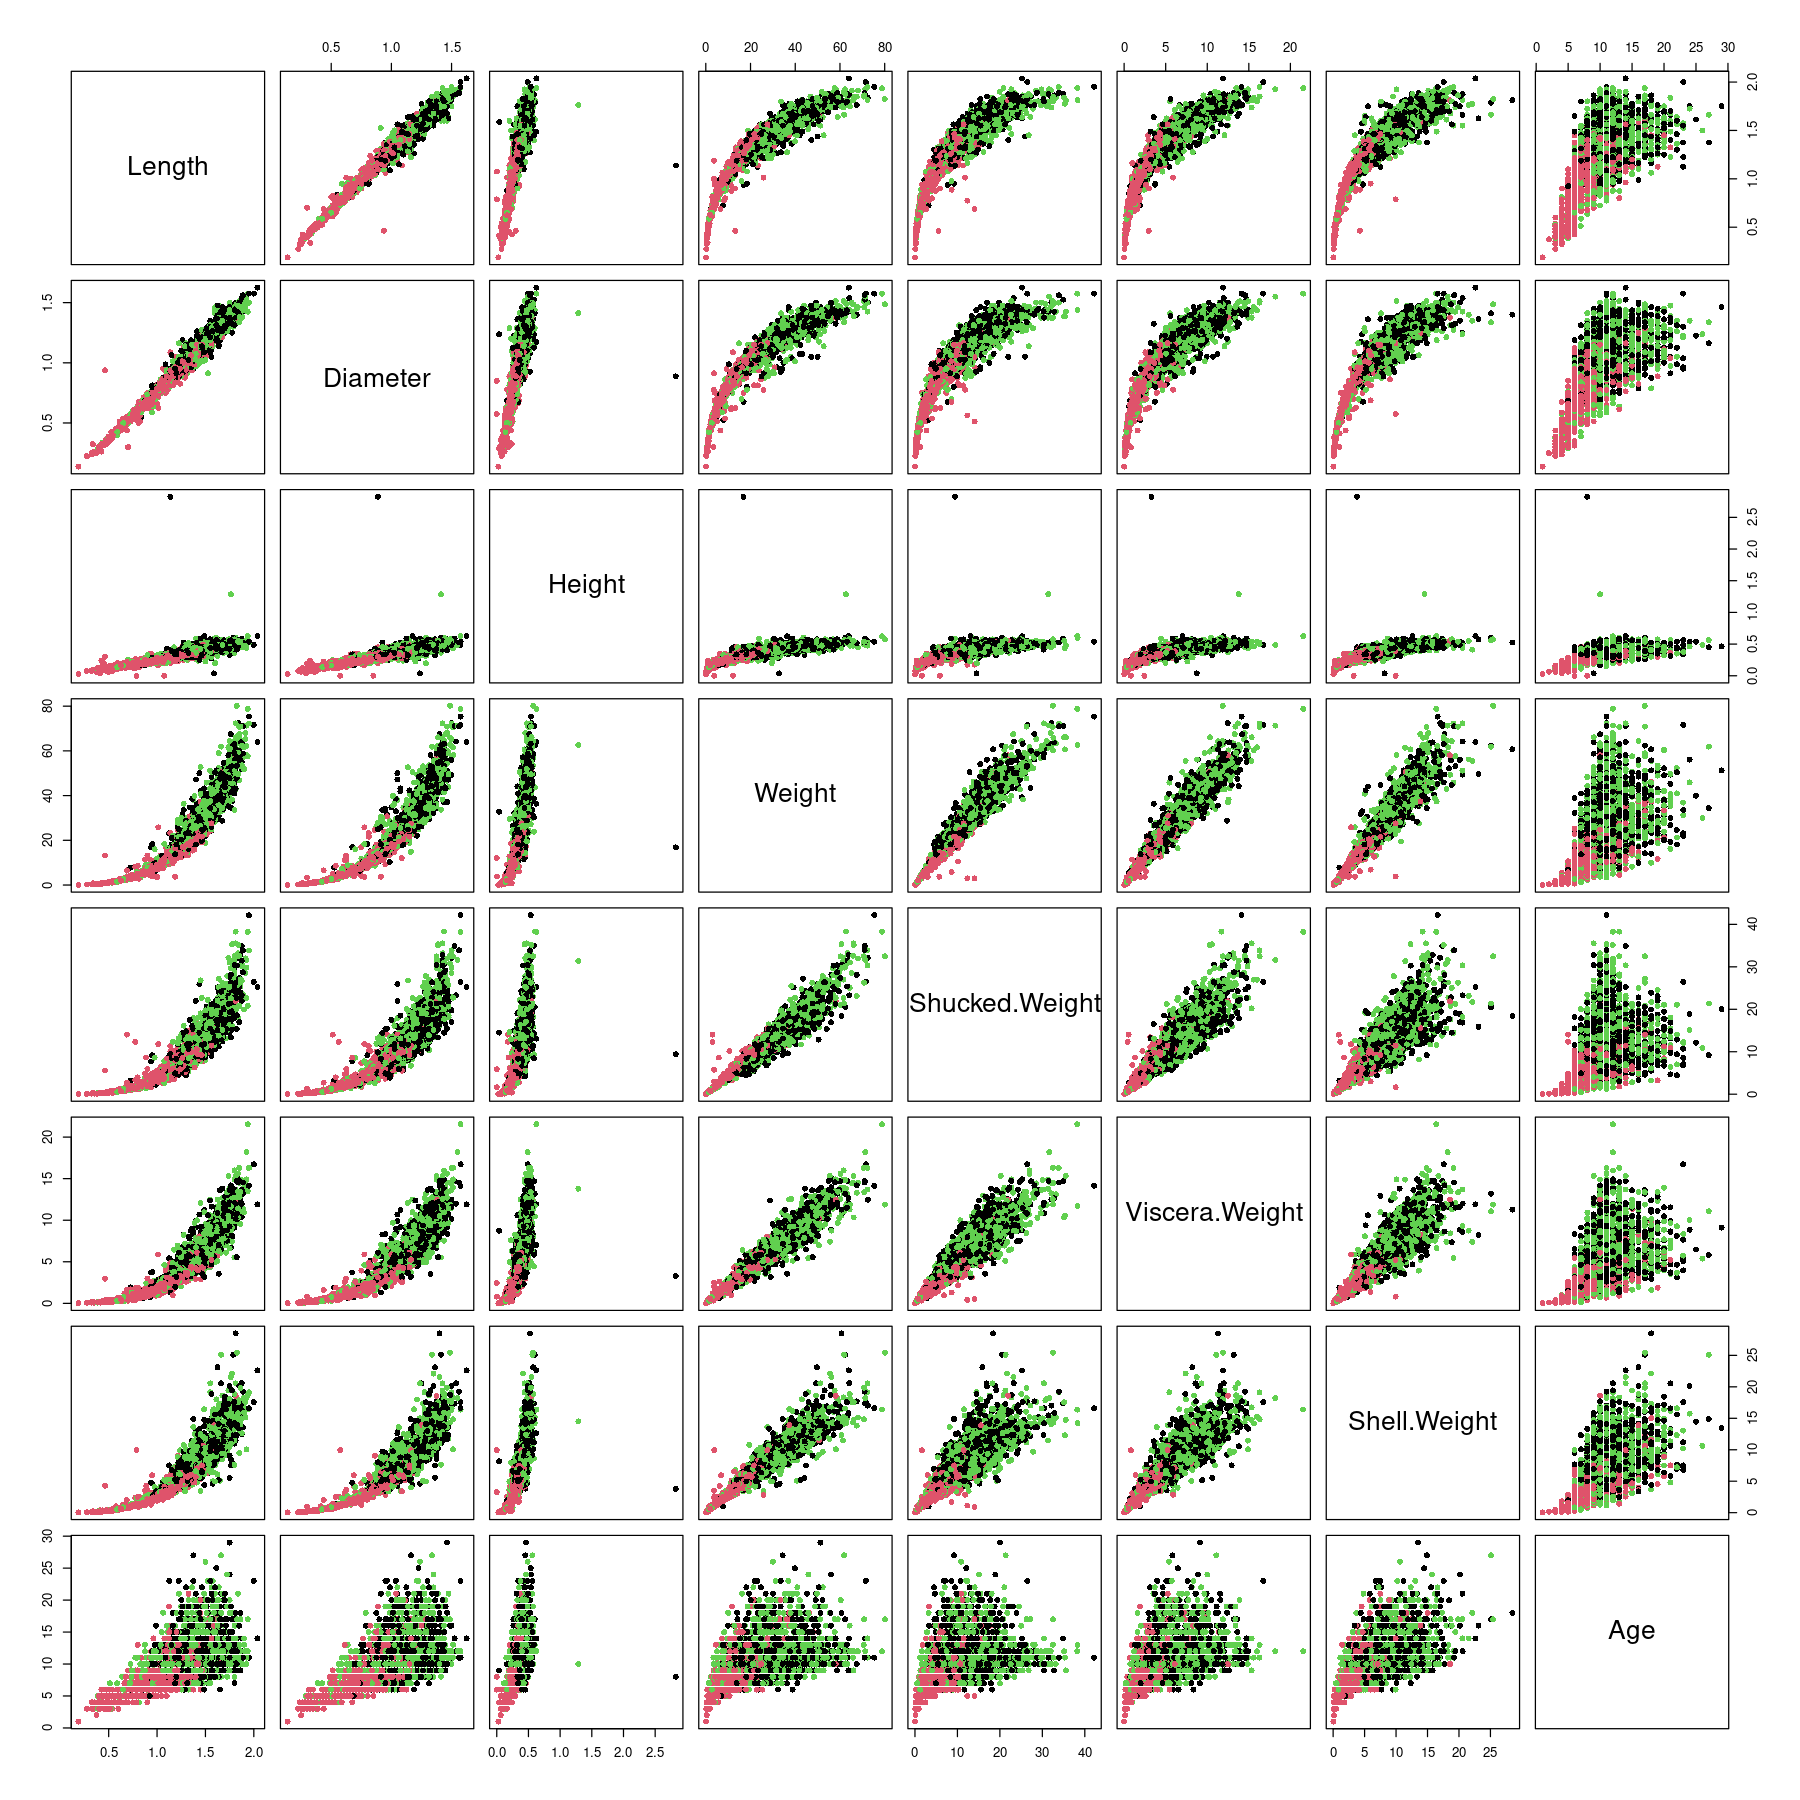

In [6]:
#Pair plot
options(repr.plot.width=15, repr.plot.height=15)
subset_data <- crabs[, c("Length", "Diameter", "Height", "Weight", 
                         "Shucked.Weight", "Viscera.Weight", "Shell.Weight", "Age", "Sex")]
pairs(subset_data[, -9], col = subset_data$Sex, cex.labels = 2, pch = 16)
legend("top", legend = levels(subset_data$Sex), col = subset_data$Sex, pch = 16, title = "Sex")

In [7]:
#Grouping by age
crabs.grouped = crabs |> group_by(Age) 
crabs.grouped = crabs.grouped |> summarize(mean.Length=mean(Length), 
        mean.Diameter=mean(Diameter), mean.Height=mean(Height), mean.Weight=mean(Weight),
            mean.Shucked.Weight=mean(Shucked.Weight), mean.Viscera.Weight=mean(Viscera.Weight),
                mean.Shell.Weight=mean(Shell.Weight), mode.Sex = mode(Sex))
crabs.grouped 

Age,mean.Length,mean.Diameter,mean.Height,mean.Weight,mean.Shucked.Weight,mean.Viscera.Weight,mean.Shell.Weight,mode.Sex
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.1875000,0.1375000,0.0250000,0.0566990,0.0283495,0.01417475,0.04252425,numeric
2,0.3750000,0.2500000,0.0625000,0.4252425,0.1275728,0.11339800,0.14174750,numeric
3,0.4413462,0.3240385,0.1048077,0.8319488,0.3510977,0.18209102,0.25950696,numeric
4,0.5558962,0.4049528,0.1360849,1.7073888,0.7071328,0.38004377,0.51644231,numeric
5,0.7105140,0.5250000,0.1739486,3.4995736,1.7385927,0.76106485,1.03065005,numeric
6,0.9209544,0.6951763,0.2287344,7.7247682,3.4915762,1.65038790,2.22225966,numeric
7,1.0525560,0.8021008,0.2637605,11.2106390,5.1669148,2.42003085,3.14584158,numeric
8,1.2526683,0.9658654,0.3239904,18.4314819,8.4440076,3.98931983,5.13226809,numeric
9,1.3659766,1.0613281,0.3571680,24.1401530,10.9648779,5.33409131,6.71431330,numeric


          Df  Pillai approx F num Df den Df    Pr(>F)    
Age        1 0.98033   142.37      7     20 1.178e-15 ***
Residuals 26                                             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Call: mardia(x = fit$residuals)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 28   num.vars =  7 
b1p =  35.97   skew =  167.85  with probability  <=  1.5e-07
 small sample skew =  190.76  with probability <=  2.8e-10
b2p =  78.49   kurtosis =  3.65  with probability <=  0.00026

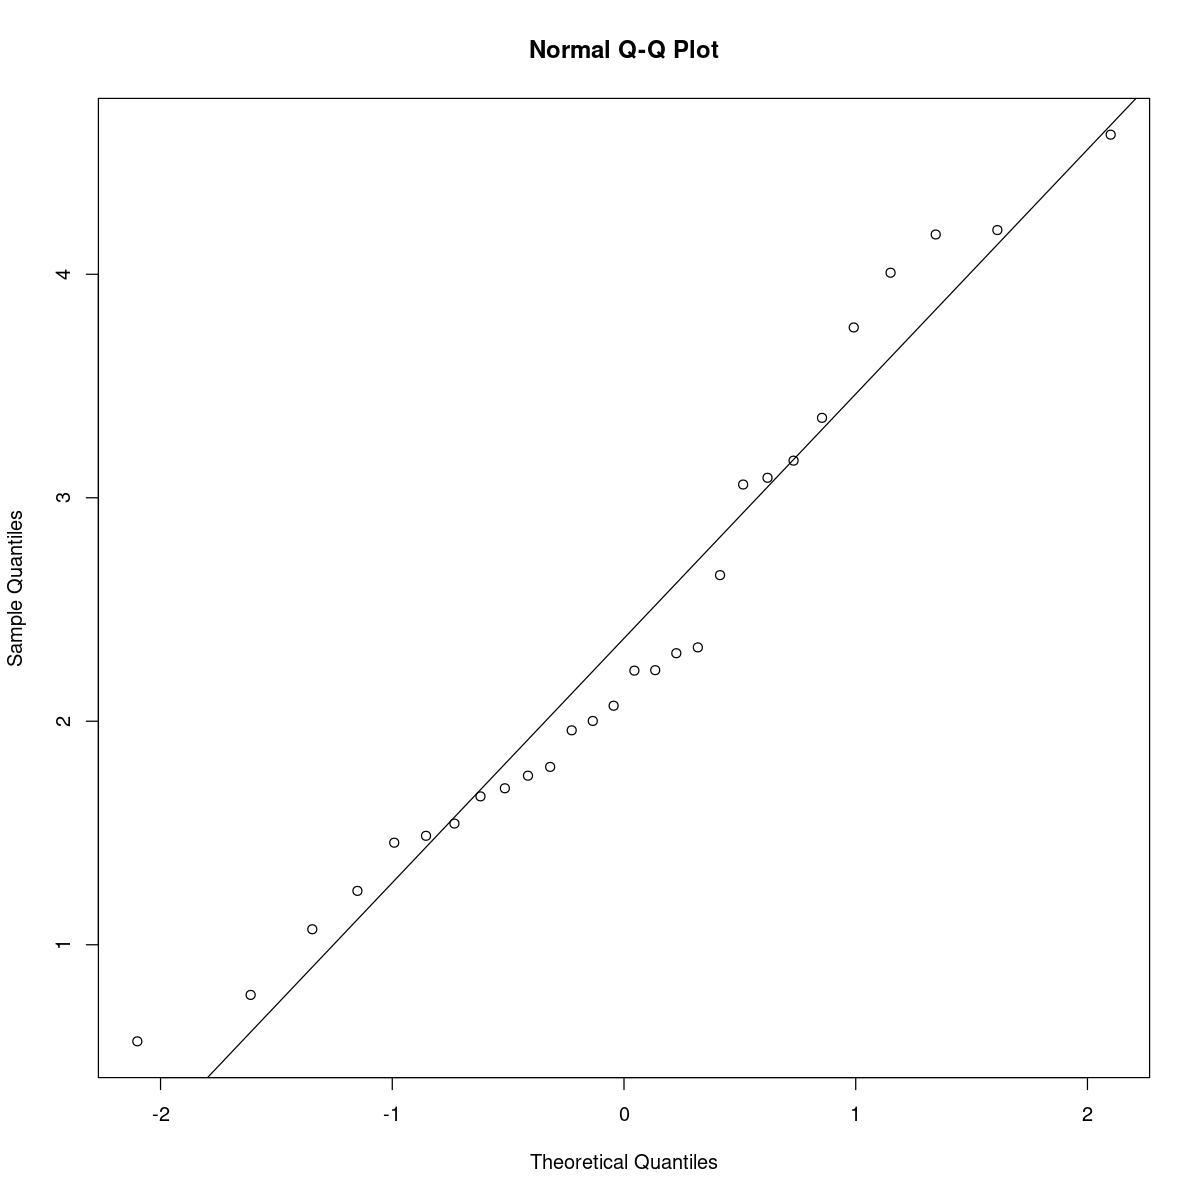

In [8]:
fit = manova(cbind(mean.Length,mean.Diameter,mean.Height,mean.Weight,
        mean.Shucked.Weight,mean.Viscera.Weight, mean.Shell.Weight) ~ Age, data = crabs.grouped)
summary(fit)
options(repr.plot.width=10, repr.plot.height=10)
mardia(fit$residuals) #normality check

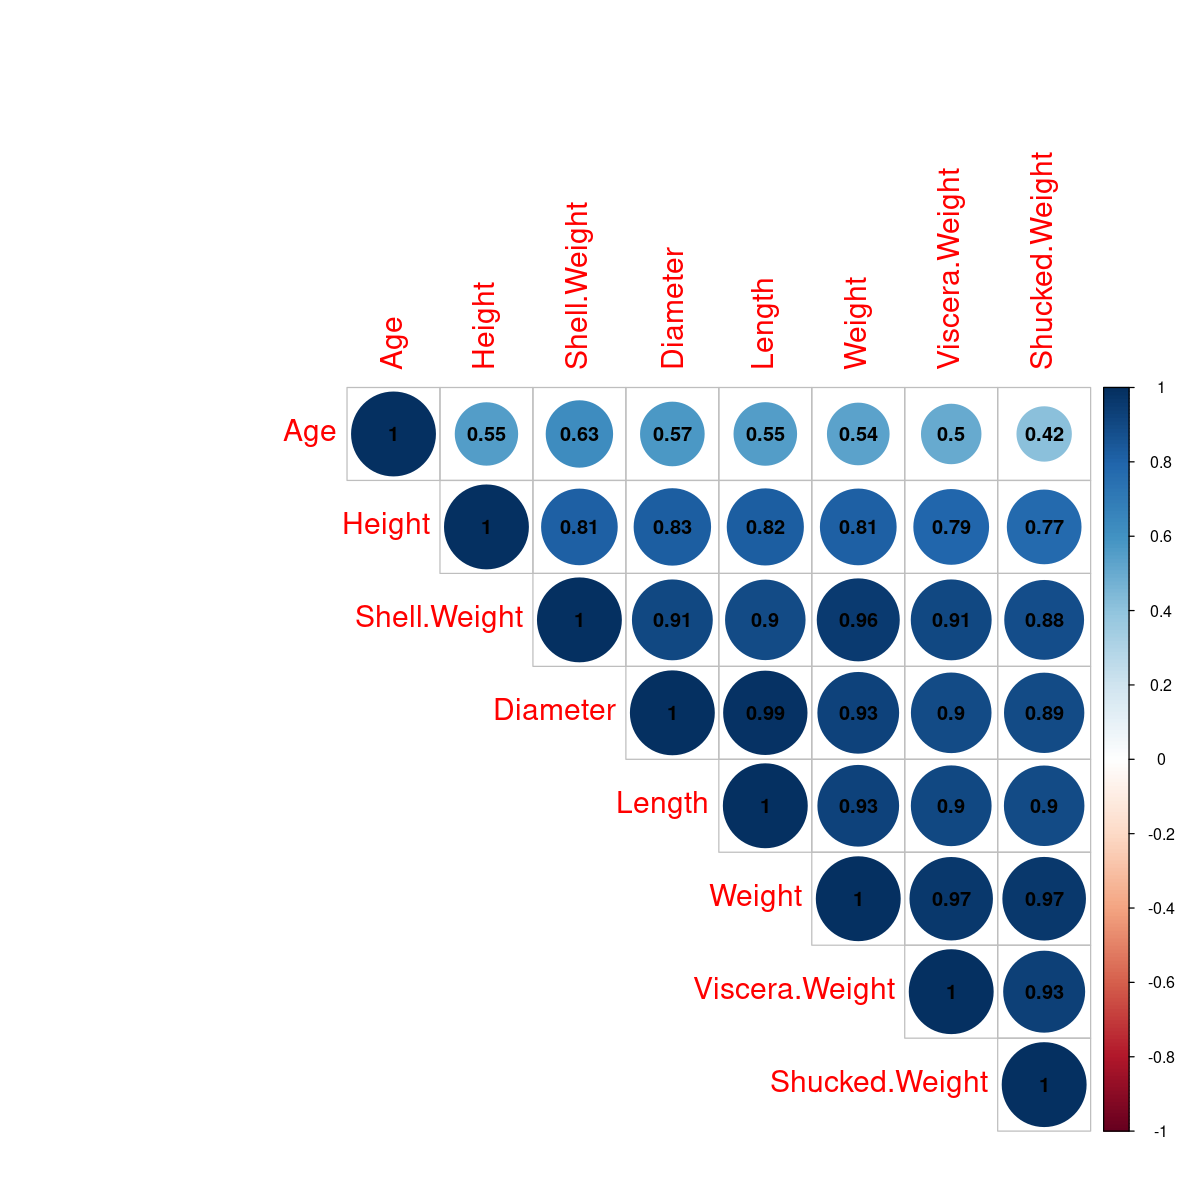

In [9]:
#Correlation matrix
cor.mat = cor(crabs[,-1])
corrplot(cor.mat, type = "upper", order = 'AOE', addCoef.col = 'black', tl.cex = 1.5)

In [10]:
#Data splitting
index.s=createDataPartition(crabs$Age, p=0.8, list=FALSE)
train=crabs[index.s,]
test=crabs[-index.s,]

In [11]:
#Multiple linear regression with model selection
lm0 = lm(Age ~ 1, data = train) #intercept-only model
lm1 = lm(Age~., data=train) #model with all variables as predictors
lm = step(lm0, direction = "forward", scope=formula(lm1), trace=0)
summary(lm)


Call:
lm(formula = Age ~ Shell.Weight + Shucked.Weight + Diameter + 
    Weight + Sex + Viscera.Weight + Height, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.6852 -1.3135 -0.3501  0.8746 13.8456 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     3.83282    0.31619  12.122  < 2e-16 ***
Shell.Weight    0.30723    0.04694   6.545 6.92e-11 ***
Shucked.Weight -0.71550    0.03312 -21.604  < 2e-16 ***
Diameter        4.48741    0.45114   9.947  < 2e-16 ***
Weight          0.32689    0.02982  10.961  < 2e-16 ***
SexI           -0.80947    0.11745  -6.892 6.64e-12 ***
SexM            0.07441    0.09590   0.776    0.438    
Viscera.Weight -0.38266    0.05226  -7.322 3.09e-13 ***
Height          3.60886    0.65637   5.498 4.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.185 on 3108 degrees of freedom
Multiple R-squared:  0.5483,	Adjusted R-squared:  0.5472 
F-statistic: 471.7 

In [12]:
#Vif
vif(lm)

,GVIF,Df,GVIF^(1/(2*Df))
Shell.Weight,22.586651,1,4.752542
Shucked.Weight,28.349015,1,5.324379
Diameter,8.245506,1,2.871499
Weight,112.824991,1,10.621911
Sex,1.536406,2,1.113337
Viscera.Weight,17.275608,1,4.156394
Height,3.222634,1,1.795170


In [13]:
#Prediction & accuracy
yhat.lm=predict(lm, test)
RMSE(test$Age, yhat.lm)
MAE(test$Age, yhat.lm)
R2(test$Age, yhat.lm)

[1] 2.239714

[1] 1.592901

[1] 0.4862988

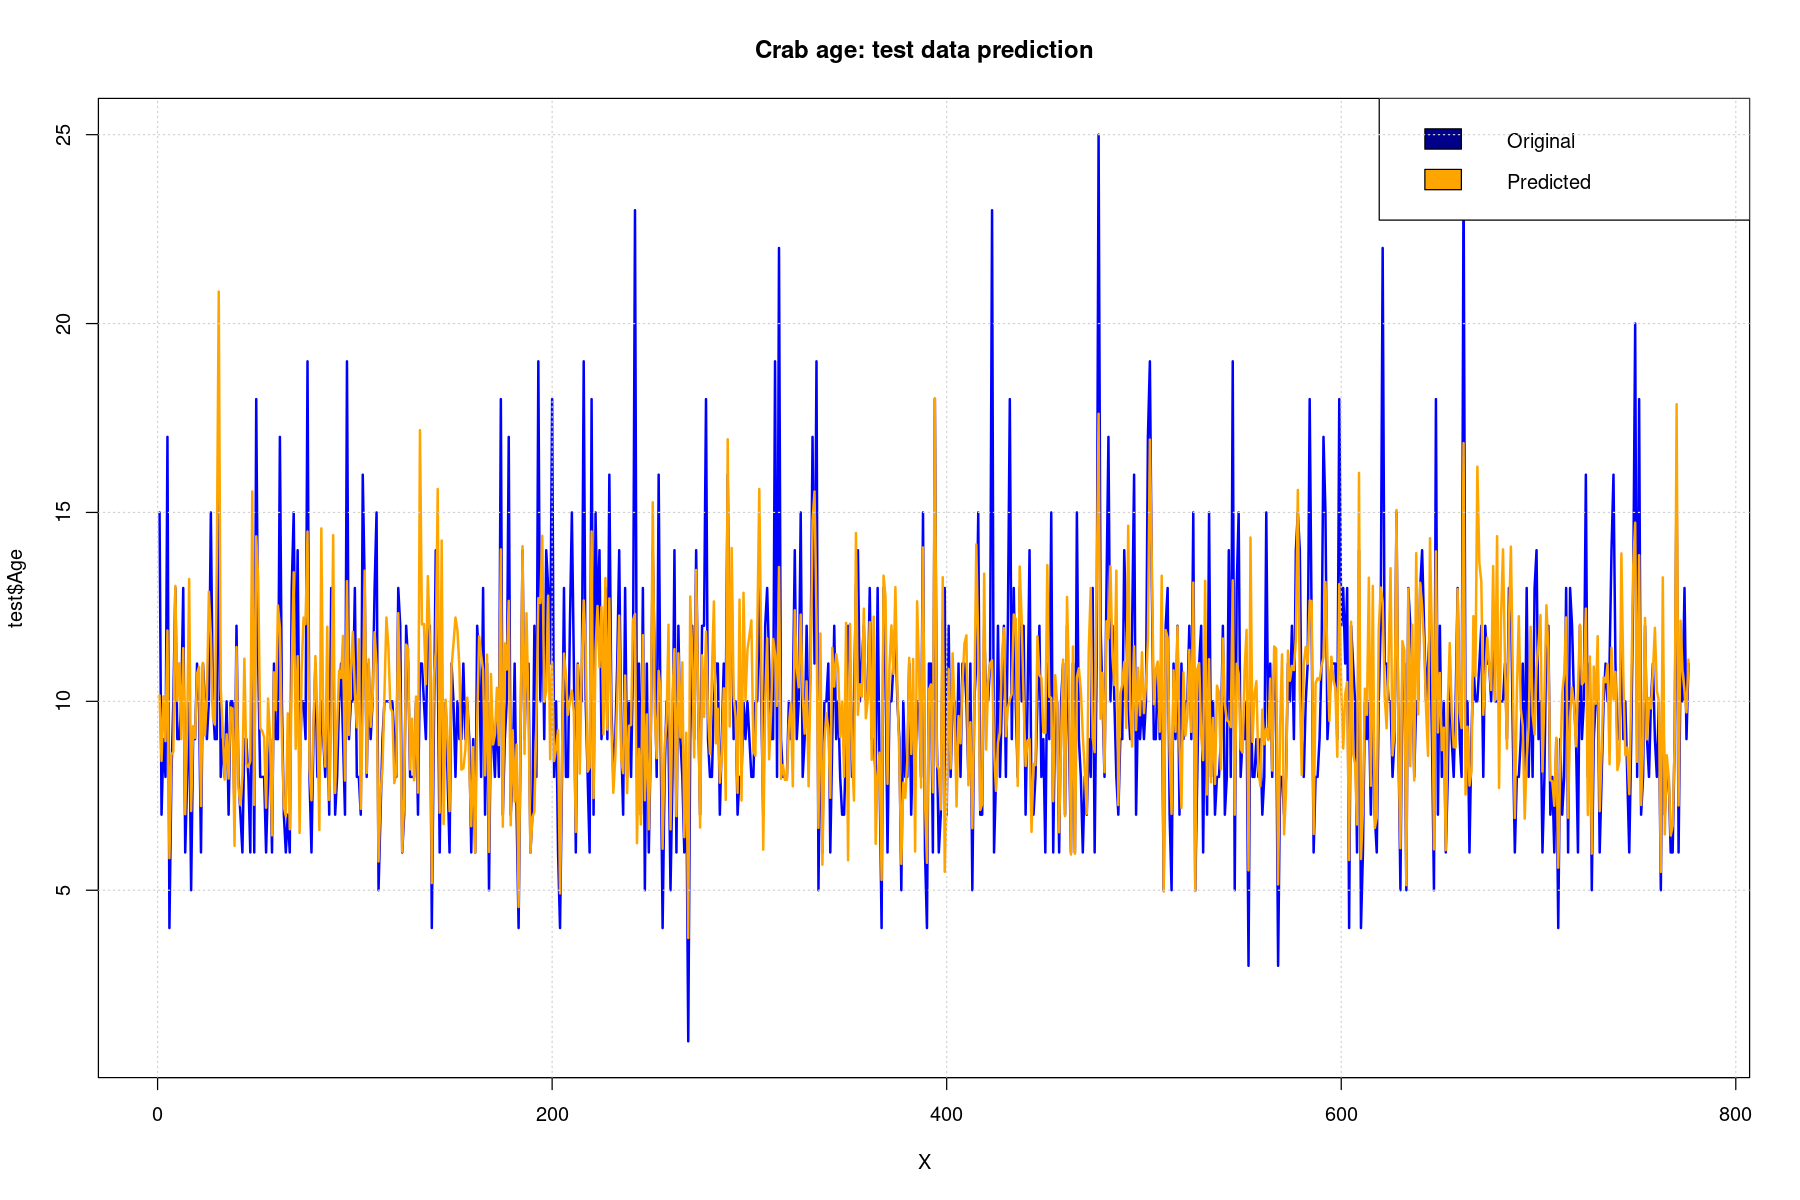

In [14]:
#Plotting predicrted values against real values for linear regression
options(repr.plot.width=15, repr.plot.height=10)
X = 1:length(yhat.lm)
plot(X, test$Age, col = 'blue', type='l', lwd=2, main = "Crab age: test data prediction")
lines(X, yhat.lm, col = 'orange', lwd = 2)
legend('topright', legend = c("Original", 'Predicted'), 
       fill = c('darkblue', 'orange'), col = 2:3, adj = c(0, 0.6))
grid()

In [15]:
#Elastic net regression
set.seed(123)
ctrl = trainControl(method = 'cv', number = 5) 
dgrid = data.frame(lambda = seq(0, 0.5,  length = 10), alpha =seq(0, 1, length = 5))
rr = train(as.matrix(train[, -9]), train$Age, method = 'glmnet', 
           tuneGrid = dgrid, trControl = ctrl, preProc = c('center', 'scale'))
rr

Warning message in pre_process_options(method, column_types):
“The following pre-processing methods were eliminated: 'center', 'scale'”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in pre_process_options(method, column_types):
“The following pre-processing methods were eliminated: 'center', 'scale'”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in pre_process_options(method, column_types):
“The following pre-processing methods were eliminated: 'center', 'scale'”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introdu

Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in pre_process_options(method, column_types):
“The following pre-processing methods were eliminated: 'center', 'scale'”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in pre_process_options(method, column_types):
“The following pre-processing methods were eliminated: 'center', 'scale'”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in pre_process_options(method, column_types):
“The following pre-processing methods were eliminated: 'cent

glmnet 

3117 samples
   8 predictor

Pre-processing: ignore (8) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2493, 2495, 2494, 2494, 2492 
Resampling results across tuning parameters:

  alpha  lambda      RMSE      Rsquared   MAE     
  0.00   0.00000000  2.323432  0.4937338  1.669885
  0.00   0.27777778  2.345008  0.4852171  1.685314
  0.25   0.05555556  2.274643  0.5120274  1.640050
  0.25   0.33333333  2.403560  0.4613685  1.732471
  0.50   0.11111111  2.314125  0.4968441  1.665412
  0.50   0.38888889  2.510336  0.4104694  1.826388
  0.75   0.16666667  2.372812  0.4735917  1.710694
  0.75   0.44444444  2.543547  0.3991240  1.858232
  1.00   0.22222222  2.494795  0.4158959  1.819188
  1.00   0.50000000  2.562374  0.3999563  1.876474

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.25 and lambda = 0.05555556.

In [16]:
#Prediction & accuracy
yhat.rr=predict(rr, test)
RMSE(test$Age, yhat.rr)
MAE(test$Age, yhat.rr)
R2(test$Age, yhat.rr)

Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”


[1] 2.291603

[1] 1.635827

[1] 0.4597585

Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”


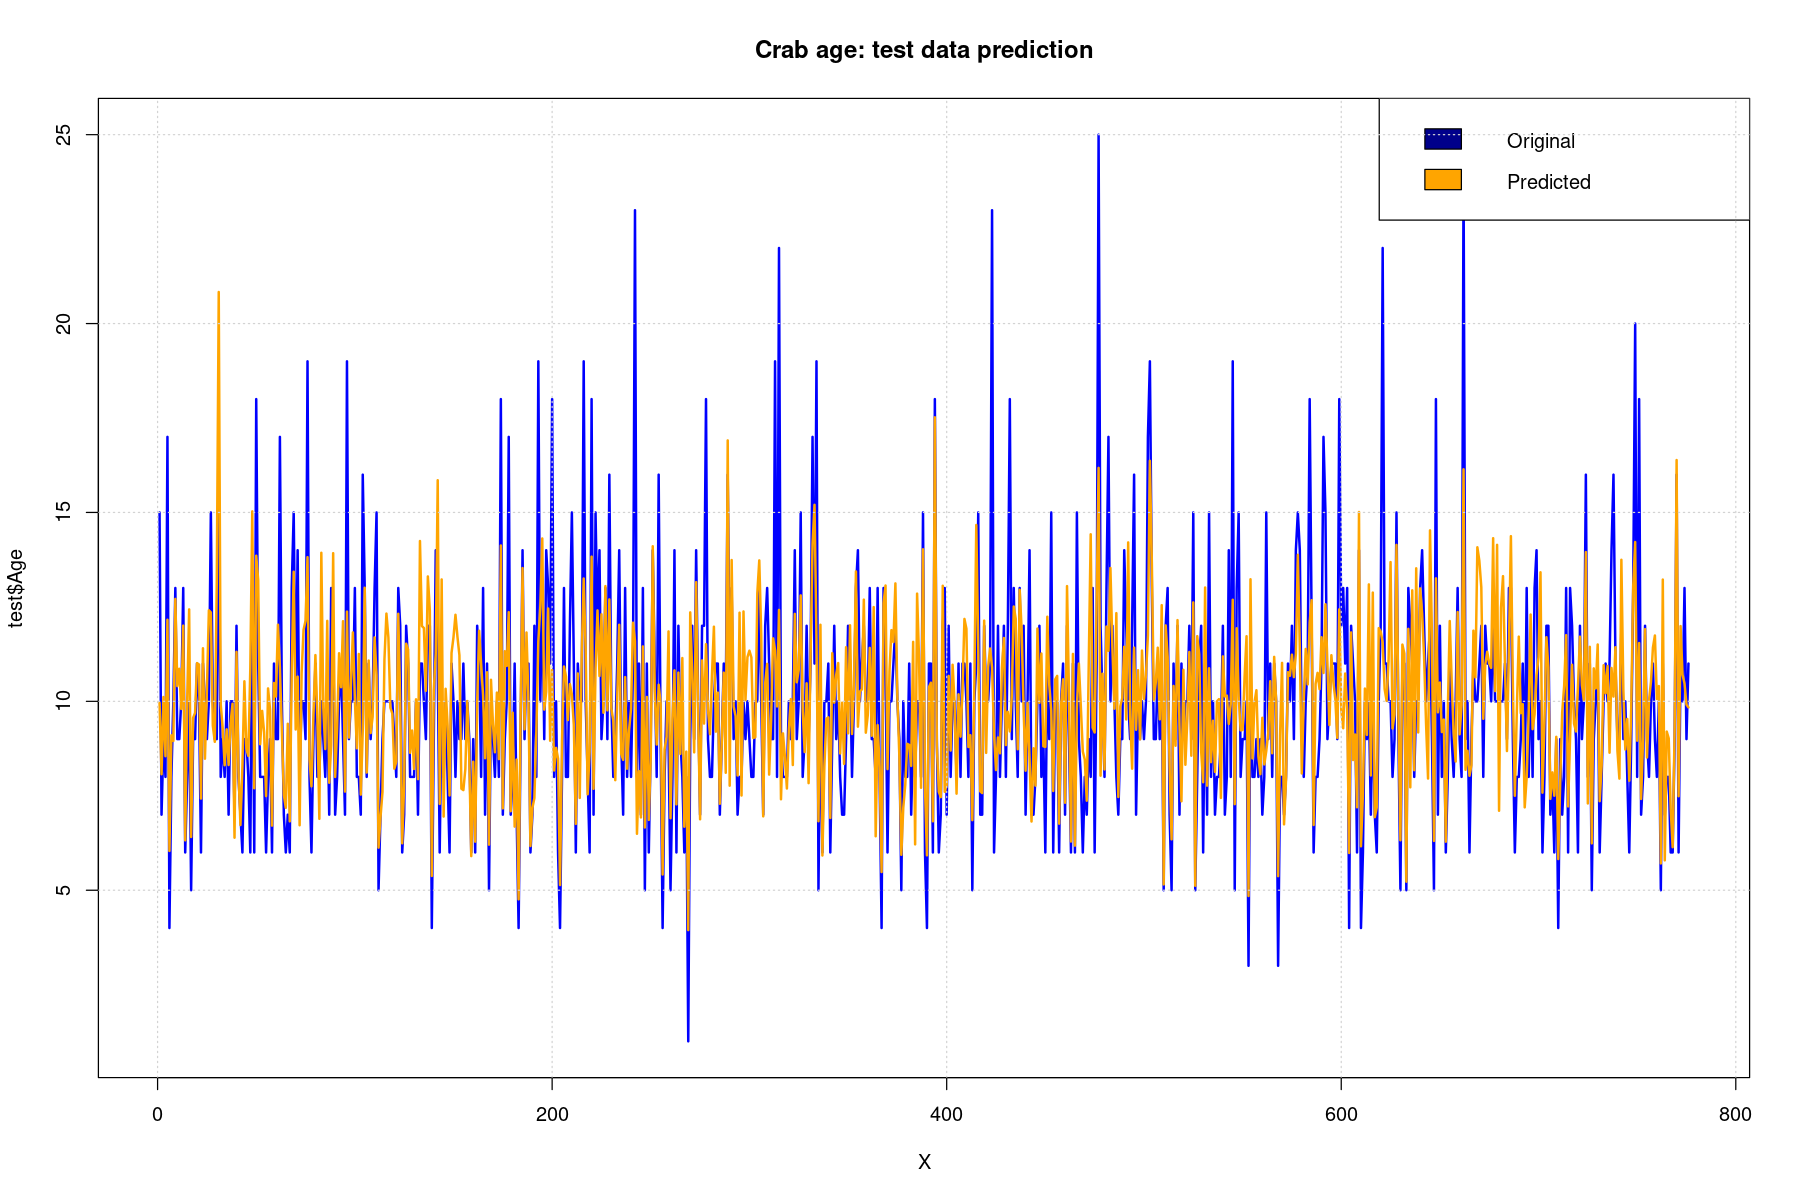

In [17]:
#Plotting predicrted values against real values for Elastic net
options(repr.plot.width=15, repr.plot.height=10)
yhat.rr = predict(rr, test)
X = 1:length(yhat.lm)
plot(X, test$Age, col = 'blue', type='l', lwd=2, main = "Crab age: test data prediction")
lines(X, yhat.rr, col = 'orange', lwd = 2)
legend('topright', legend = c("Original", 'Predicted'), 
       fill = c('darkblue', 'orange'), col = 2:3, adj = c(0, 0.6))
grid()

In [18]:
#K-Nearest Neighbours, k=10
knn = train(Age ~., data = train, method = "knn", trControl = ctrl, 
            tuneGrid = data.frame(k=1:10), preProcess = c('center', 'scale'))
knn$bestTune
knn

,k
,<int>
10,10


k-Nearest Neighbors 

3117 samples
   8 predictor

Pre-processing: centered (9), scaled (9) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2493, 2493, 2494, 2494, 2494 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
   1  2.949219  0.3273843  2.023745
   2  2.568161  0.4145064  1.802154
   3  2.431680  0.4557884  1.707806
   4  2.342655  0.4852385  1.655997
   5  2.310639  0.4968054  1.622564
   6  2.305114  0.4991308  1.608283
   7  2.287909  0.5073475  1.592314
   8  2.285602  0.5084154  1.590927
   9  2.276777  0.5122786  1.588318
  10  2.267434  0.5167315  1.579374

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 10.

In [19]:
#Prediction & accuracy
yhat.knn=predict(knn, test)
RMSE(test$Age, yhat.knn)
MAE(test$Age, yhat.knn)
R2(test$Age, yhat.knn)

[1] 2.253963

[1] 1.562395

[1] 0.4782968

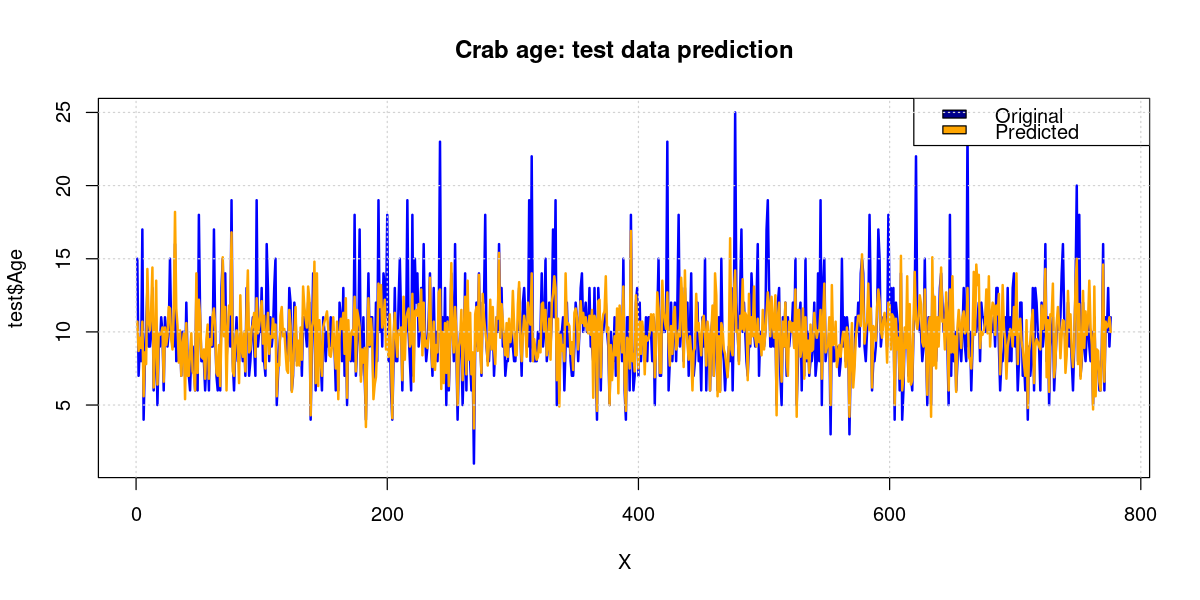

In [20]:
#Plotting predicrted values against real values for KNN
options(repr.plot.width=10, repr.plot.height=5)
X = 1:length(yhat.knn)
plot(X, test$Age, col = 'blue', type='l', lwd=2, main = "Crab age: test data prediction")
lines(X, yhat.knn, col = 'orange', lwd = 2)
legend('topright', legend = c("Original", 'Predicted'), fill = c('darkblue', 'orange'), col = 2:3, adj = c(0, 0.6))
grid()

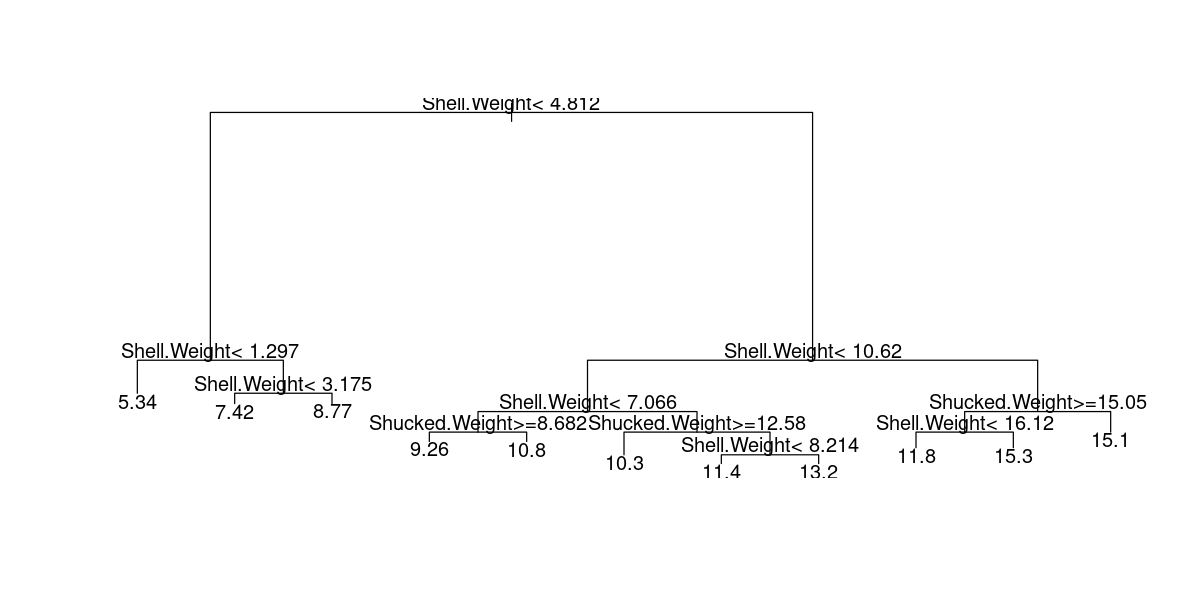

In [21]:
#CART model
cart = rpart(Age~., data = train)
plot(cart)
text(cart, digits =3)

In [22]:
#Prediction & accuracy
yhat.cart = predict(cart, test)
MAE(test$Age, yhat.cart)
RMSE(test$Age, yhat.cart)
R2(test$Age, yhat.cart)

[1] 1.705295

[1] 2.395056

[1] 0.4162387

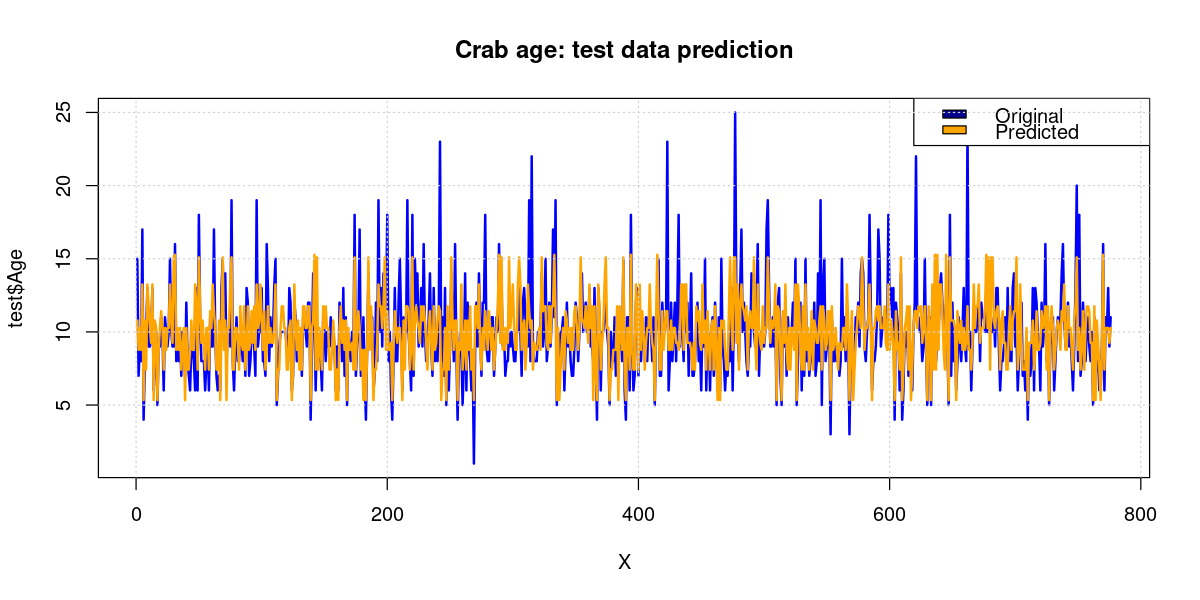

In [23]:
#Plotting predicrted values against real values for CART
X = 1:length(yhat.cart)
plot(X, test$Age, col = 'blue', type='l', lwd=2, main = "Crab age: test data prediction")
lines(X, yhat.cart, col = 'orange', lwd = 2)
legend('topright', legend = c("Original", 'Predicted'), fill = c('darkblue', 'orange'), col = 2:3, adj = c(0, 0.6))
grid()